# Weather data analysis and classification of seasons

## Objective

The objective of this project is to explore and analyze weather data and prepare the classification of seasons.

In [2]:
#!pip install optuna # Run in Google Colab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.4 MB/s eta 0:00:00


In [3]:
from datetime import date

import matplotlib.pyplot as plt
import missingno
import numpy as np
import numpy.typing as npt
import optuna
import pandas as pd
import seaborn as sns
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (ConfusionMatrixDisplay, auc,
                             classification_report, confusion_matrix,
                             precision_recall_curve)
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (FunctionTransformer, LabelBinarizer,
                                   LabelEncoder, StandardScaler)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


pd.set_option("display.float_format","{:.2f}".format)

DATA_PATH = "krakow-hourly-weather-si.csv"

## Exploratory data analysis

### Data description

Data collected from the DarkSky platform includes weather information from the Krakow city area (data collected at the Balice-Port Lotniczy weather station) from the last 20 years, i.e. from January 1, 2000, to
December 31, 2020, reported with a frequency of 1 hour. Data for further processing were saved in a CSV file. The dataset originally consisted of 71074 observations and 21 columns. The `longitude` and `latitude` columns were removed as they contained only one value - coordinates of the weather station.

In [4]:
excluded_columns = ["longitude", "latitude"]

# Read only necessery columns
raw_df = pd.read_csv(DATA_PATH).drop(columns=excluded_columns)

# Convert 'time' from unix timestamp to datetime
raw_df["time"] = pd.to_datetime(raw_df["time"], unit="s", utc=True).dt.tz_convert(tz="Europe/Warsaw")
raw_df = raw_df.set_index("time")

In [ ]:
raw_df.head()

,icon,summary,precipIntensity,precipProbability,precipType,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,ozone,precipAccumulation
time,,,,,,,,,,,,,,,,,,
2007-05-16 00:00:00+02:00,NaN,NaN,NaN,NaN,NaN,13.19,13.19,12.00,0.92,NaN,1.02,NaN,191.00,0.75,0.00,10.00,NaN,NaN
2007-05-16 01:00:00+02:00,NaN,NaN,NaN,NaN,NaN,13.19,13.19,12.00,0.92,NaN,0.00,NaN,NaN,0.75,0.00,10.00,NaN,NaN
2007-05-16 02:00:00+02:00,NaN,NaN,NaN,NaN,NaN,13.19,13.19,12.00,0.92,1009.30,1.02,NaN,60.00,0.75,0.00,10.00,NaN,NaN
2007-05-16 03:00:00+02:00,NaN,NaN,NaN,NaN,NaN,13.19,13.19,12.00,0.92,NaN,1.02,NaN,90.00,0.75,0.00,10.00,NaN,NaN
2007-05-16 04:00:00+02:00,NaN,NaN,NaN,NaN,NaN,12.19,12.19,12.00,0.99,NaN,0.00,NaN,NaN,0.75,0.00,3.50,NaN,NaN


In [ ]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 71074 entries, 2007-05-16 00:00:00+02:00 to 2006-05-20 23:00:00+02:00
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   icon                 25869 non-null  object 
 1   summary              25869 non-null  object 
 2   precipIntensity      26700 non-null  float64
 3   precipProbability    26700 non-null  float64
 4   precipType           4216 non-null   object 
 5   temperature          71068 non-null  float64
 6   apparentTemperature  71068 non-null  float64
 7   dewPoint             71069 non-null  float64
 8   humidity             71067 non-null  float64
 9   pressure             53030 non-null  float64
 10  windSpeed            70726 non-null  float64
 11  windGust             17431 non-null  float64
 12  windBearing          63704 non-null  float64
 13  cloudCover           64749 non-null  float64
 14  uvIndex              68263 non-null  fl

### Features description

In [28]:
data_desc = [
    {"unit": "UNIX timestamp", "feature": "time", "desc": "Observation time"},
    {"unit": "-", "feature": "icon", "desc": "Weather condition icon"},
    {"unit": "-", "feature": "summary", "desc": "Weather condition text description"},
    {"unit": "mm/h", "feature": "precipIntensity", "desc": "Precipitation intensity"},
    {"unit": "%", "feature": "precipProbability", "desc": "Precipitation probability"},
    {"unit": "-", "feature": "precipType", "desc": "Precipitation type"},
    {"unit": "\N{DEGREE SIGN}C", "feature": "temperature", "desc": "Air temperature"},
    {"unit": "\N{DEGREE SIGN}C", "feature": "apparentTemperature", "desc": "Air apparent temperature"},
    {"unit": "\N{DEGREE SIGN}C", "feature": "dewPoint", "desc": "Dew point"},
    {"unit": "% H2O", "feature": "humidity", "desc": "Air humidity"},
    {"unit": "hPa", "feature": "pressure", "desc": "Atmospheric pressure"},
    {"unit": "m/s", "feature": "windSpeed", "desc": "Wind speed"},
    {"unit": "m/s", "feature": "windGust", "desc": "Wind gusts"},
    {"unit": "\N{DEGREE SIGN} [0-360)", "feature": "windBearing", "desc": "Wind direction"},
    {"unit": "%", "feature": "cloudCover", "desc": "Percentage of sky cloud cover"},
    {"unit": "int in range [0, 9]", "feature": "uvIndex", "desc": "Sunlight level (UV)"},
    {"unit": "km", "feature": "visibility", "desc": "Visibility"},
    {"unit": "mm", "feature": "ozone", "desc": "Air ozone level"},
    {"unit": "mm", "feature": "precipAccumulation", "desc": "Accumulation of precipitation"},
]
pd.DataFrame.from_records(data_desc)[["feature", "desc", "unit"]].rename(columns={"desc": "description"}).set_index("feature").sort_index()

,description,unit
feature,,
apparentTemperature,Air apparent temperature,°C
cloudCover,Percentage of sky cloud cover,%
dewPoint,Dew point,°C
humidity,Air humidity,% H2O
icon,Weather condition icon,-
ozone,Air ozone level,mm
precipAccumulation,Accumulation of precipitation,mm
precipIntensity,Precipitation intensity,mm/h
precipProbability,Precipitation probability,%


The first step is to convert the data from hourly to daily, calculating the average values ​​for each feature and the minimum and maximum temperatures during the day.

In [5]:
df_daily = raw_df.groupby(raw_df.index.date)
df_mean = df_daily.mean(numeric_only=True)

df_min_max_sum = df_daily.agg(
    min_temperature=("temperature", "min"),
    max_temperature=("temperature", "max"),
    max_windSpeed=("windSpeed", "max"),
    max_windGust=("windGust", "max"),
    precipAccumulation = ("precipAccumulation", "sum")
)

df_mean["uvIndex"] = raw_df["uvIndex"].replace(0, np.nan).groupby(raw_df.index.date).mean(numeric_only=True)

df = df_mean.drop(columns=["precipAccumulation"]).join(df_min_max_sum).sort_index(axis=0).sort_index(axis=1)
df.index = pd.to_datetime(df.index)

In [6]:
# Reduce memory usage
numeric_df = df.select_dtypes(np.number)
df[numeric_df.columns] = numeric_df.astype(np.float32)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2966 entries, 2000-01-01 to 2020-12-31
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   apparentTemperature  2966 non-null   float32
 1   cloudCover           2950 non-null   float32
 2   dewPoint             2966 non-null   float32
 3   humidity             2966 non-null   float32
 4   max_temperature      2966 non-null   float32
 5   max_windGust         868 non-null    float32
 6   max_windSpeed        2966 non-null   float32
 7   min_temperature      2966 non-null   float32
 8   ozone                247 non-null    float32
 9   precipAccumulation   2966 non-null   float32
 10  precipIntensity      1115 non-null   float32
 11  precipProbability    1115 non-null   float32
 12  pressure             2810 non-null   float32
 13  temperature          2966 non-null   float32
 14  uvIndex              2925 non-null   float32
 15  visibility          

### Qualitative analysis

Qualitative analysis allows quickly get insights about the data e.g. data distribution, missing observations and outliers, feature correlations, possible data transformations etc.

In [ ]:
pd.concat([
    df.describe(),
    pd.DataFrame({"skew": df.skew(numeric_only=True), "kurtosis": df.kurtosis(numeric_only=True)}).T,
])

,apparentTemperature,cloudCover,dewPoint,humidity,max_temperature,max_windGust,max_windSpeed,min_temperature,ozone,precipAccumulation,precipIntensity,precipProbability,pressure,temperature,uvIndex,visibility,windBearing,windGust,windSpeed
count,2966.00,2950.00,2966.00,2966.00,2966.00,868.00,2966.00,2966.00,247.00,2966.00,1115.00,1115.00,2810.00,2966.00,2925.00,2032.00,2966.00,868.00,2966.00
mean,8.32,0.57,4.77,0.76,13.90,7.66,5.31,5.13,315.04,0.05,0.17,0.04,1016.94,9.47,2.39,8.89,176.07,5.33,2.74
std,9.89,0.25,8.06,0.12,9.84,4.63,2.40,7.88,38.25,2.10,3.25,0.09,7.96,8.59,1.22,3.38,75.69,4.65,1.53
min,-28.41,0.00,-29.12,0.13,-18.87,1.27,0.51,-26.83,236.73,0.00,0.00,0.00,981.91,-22.34,1.00,0.31,16.58,0.59,0.02
25%,0.61,0.39,-0.49,0.68,5.99,4.27,3.60,-0.40,287.02,0.00,0.00,0.00,1012.03,2.93,1.00,7.06,100.52,2.07,1.62
50%,9.33,0.61,5.31,0.78,14.24,6.20,5.00,5.21,309.77,0.00,0.00,0.00,1016.70,9.86,2.25,9.34,193.13,3.28,2.42
75%,16.54,0.76,11.09,0.85,22.10,10.80,6.69,11.34,339.00,0.00,0.01,0.05,1021.75,16.49,3.40,10.00,243.20,6.59,3.50
max,29.76,1.00,20.33,0.99,35.19,26.74,20.00,22.41,415.97,111.96,100.00,1.00,1049.93,29.53,5.86,16.09,339.29,19.55,10.31
skew,-0.34,-0.38,-0.59,-0.87,-0.17,0.96,1.07,-0.40,0.51,51.46,27.74,3.40,0.06,-0.26,0.34,0.31,-0.26,1.29,1.13
kurtosis,-0.63,-0.70,0.32,1.44,-0.83,0.18,2.28,-0.16,-0.23,2732.57,822.57,16.42,0.75,-0.58,-1.13,0.45,-1.33,0.37,1.51


Main insights from qualitative analysis :
  - variables: `temperature`, `apparentTemperature`, `pressure`, `cloudCover`, `visibility`, `ozone`, `dewPoint` come from distributions close to normal (similar mean and median, |skew| < 1, |kurtosis| < 1),
  - `temperature` reaches min. -27 and max. 35 degrees Celsius, while the `apparentTemperature` is -32 and 37 degrees Celsius, respectively,
  - observations for the precipitation variables do not come from a normal distribution; many extremely high values are observed,
  - approximately half of the winds are from the east-south, south, south-west and west,
  - the average `temperature` is 9.47 degrees Celsius,
  - average `pressure` is 1017 hPa,
  - average `visibility` is 8.90 km,
  - on average, more than half of the sky (57%) is cloudy,
  - the speed of half of the winds is in averge less than 2.4 m/s, extremely up to 20 m/s,
  - wind gusts reach up to 26 m/s,
  - the largest range of values is observed for precipitation variables (intensity and accumulation).

In [ ]:
def determine_season(observation_date: date) -> str:
    """Determine a season for a given date.

    Args:
        observation_date (date): Datetime

    Returns:
        str: Season; one of ['winter', 'spring', 'summer', 'autumn']
    """
    year = observation_date.year

    conditions = (
        ("winter", date(year, 1, 1), date(year, 3, 20)),
        ("spring", date(year, 3, 21), date(year, 6, 20)),
        ("summer", date(year, 6, 21), date(year, 9, 22)),
        ("autumn", date(year, 9, 23), date(year, 12, 20)),
        ("winter",  date(year, 12, 21), date(year, 12, 31)),
    )

    return [season for season, start, end in conditions if start <= observation_date <= end][0]

df["season"] = [determine_season(index.date()) for index, _ in df.iterrows()]

Text(0, 0.5, 'Days')

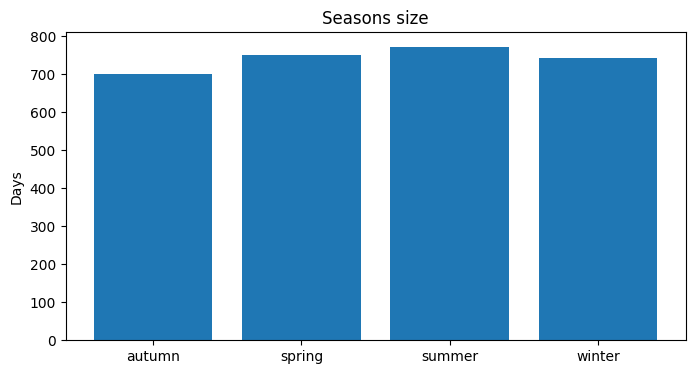

In [ ]:
seasons_count = df.groupby("season").size()

_, ax = plt.subplots(figsize=(8, 4))
ax.bar(x=seasons_count.index, height=seasons_count.values)
ax.set_title("Seasons size")
ax.set_ylabel("Days")

As you can see, the seasons are well balanced in terms of number of days, with approximately 750 days for each season.

### Identifing missing data

Missing data is a problem especially for small datasets. Our dataset has almost 3000 observations, but handling missing data is as important as in the case of smaller datasets.

In [ ]:
missing_data_count = df.isna().sum()
pd.DataFrame({"data_missing_amount": missing_data_count, "data_missing_prct": missing_data_count / df.shape[0] * 100}).sort_values(by="data_missing_prct", ascending=False)

,data_missing_amount,data_missing_prct
ozone,2719,91.67
windGust,2098,70.73
max_windGust,2098,70.73
precipIntensity,1851,62.41
precipProbability,1851,62.41
visibility,934,31.49
pressure,156,5.26
uvIndex,41,1.38
cloudCover,16,0.54
windSpeed,0,0.00


For 5 features, more than 50% of the data are missing. However, these columns do not contain the most important information, so some of them can be safely removed (features: `max_windGust`, `ozone`, `windGust`, `precipIntensity`, `precipProbability`).

The `summary` and `icon` features summarize the current weather based on all other features and are therefore highly correlated with them and as such should not be included in the training set. They has already been removed.

In the case of other features, an appropriate method will be used to fill in the missing values, described in more detail in one of the following section.

<Axes: >

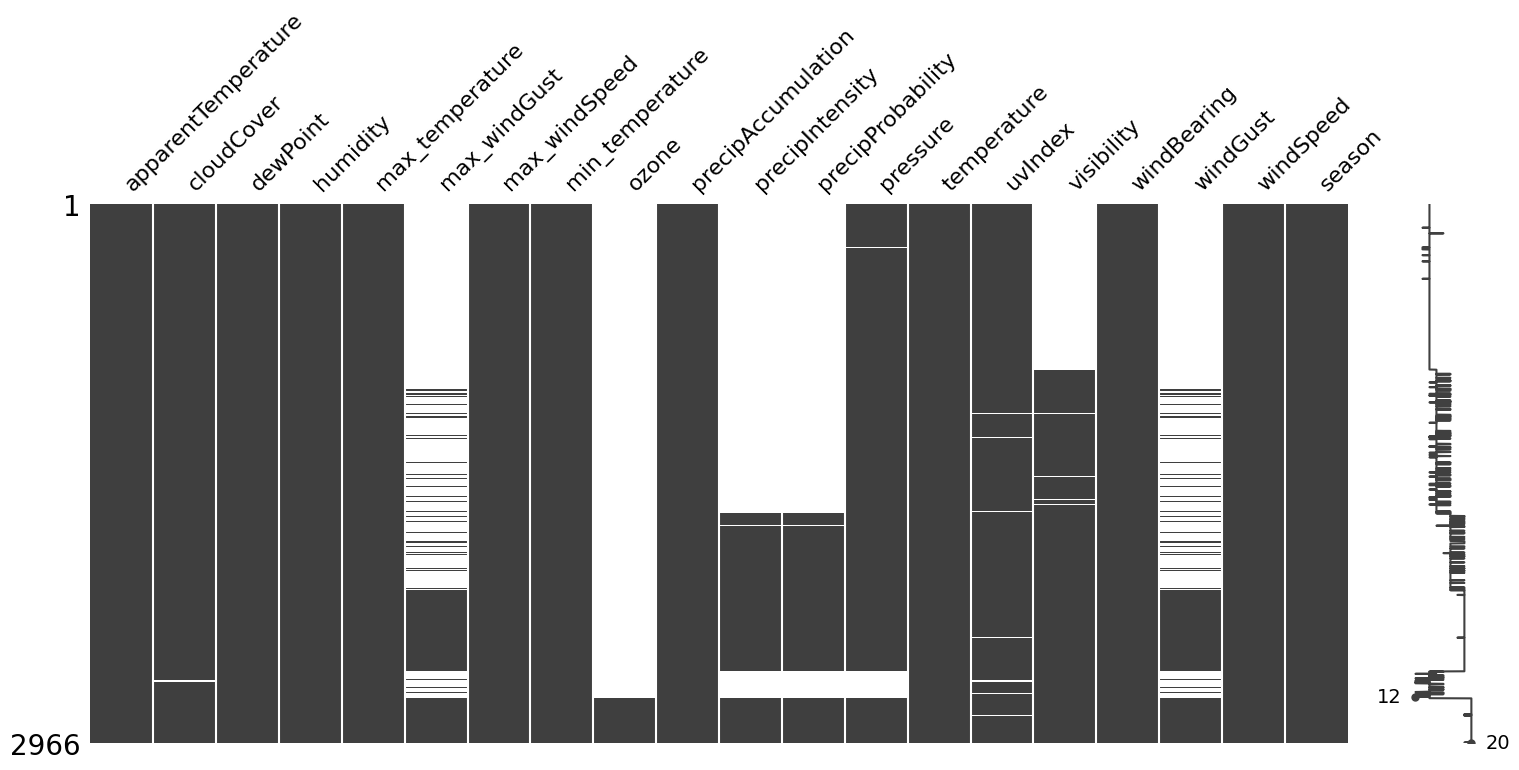

In [ ]:
missingno.matrix(df, figsize=(18, 7))

In [ ]:
df.loc[df["visibility"].notna()].index[:3]

DatetimeIndex(['2006-03-22', '2006-03-27', '2006-04-01'], dtype='datetime64[ns]', freq=None)

In [ ]:
df.loc[df["ozone"].notna()].index[:3]

DatetimeIndex(['2019-05-25', '2019-05-26', '2019-05-28'], dtype='datetime64[ns]', freq=None)

In [ ]:
df.loc[df["windGust"].notna()].index[:3]

DatetimeIndex(['2006-06-01', '2006-06-05', '2006-07-16'], dtype='datetime64[ns]', freq=None)

There are clear patterns in the missing data in the chart above. Some features are collected not from the beginning of observations, but for some time. The `precipIntenstity` and `precipProbability` variables have been detected relatively continuously since approximately 2012, the `visibility` variable since 2006, and `ozone` since mid-2019. This may be related to, for example, retrofitting the weather station with new detectors or changes in the guidelines for collecting meteorological data.

The `windGust` variable has been measured with large breaks since 2006 and more regularly since 2013. Atmospheric `pressure`, although measured since the beginning of observations, has a period from 2006 to approximately 2010 in which the data are collected at long intervals. Around 2018, a large break in the measurement of many features (at least 9) can be observed.

### Identifing outliers

Some observations lies far away from others - they are outliers. Outliers can significantly decrease model performance by providing noise and nonreprezentative data.

In [ ]:
def iqr(df: pd.DataFrame, iqr_mutliplier: int=1.5) -> tuple[pd.DataFrame, pd.Series]:
    """Determine outliers using the IQR method.

    Args:
        df (pd.DataFrame): Data for which outliers will be identified
        iqr_mutliplier (int, optional): IQR multiplier - the larger it is, the
        greater the tolerance for outliers. Default 1.5

    Returns:
        tuple[pd.DataFrame, pd.Series]: Outlier data frame and outlier count
        foar each feature
    """
    x = df.quantile([0.25, 0.75], numeric_only=True)
    q25 = x.loc[0.25]
    q75 = x.loc[0.75]
    iqr_range = q75 - q25

    iqr_bound = iqr_mutliplier * iqr_range

    lower = q25 - iqr_bound
    upper = q75 + iqr_bound

    # Observations where at least one feature is outlier
    df, lower = df.align(lower, axis=1, copy=False)
    df, upper = df.align(upper, axis=1, copy=False)
    outliers = (df < lower) | (df > upper)

    outliers_mask = outliers.sum(axis=1).astype(bool).values
    outliers_features_count = outliers.sum(axis=0).sort_values(ascending=False)

    return df[outliers_mask], outliers_features_count


outliers, outliers_features_count = iqr(df)

In [ ]:
round(outliers.shape[0] / df.shape[0] * 100, 2)

23.2

About 23% of all observations are outliers. The IQR method was used to detect them - observations for which at least one feature is smaller than the lower quantile - 1.5IQR or is greater than the upper quantile + 1.5IQR are considered outliers. This number of outliers is significant and cannot be ignored (often, if the number of outliers is less than a dozen or so percent, nothing is done about them).

In [ ]:
pd.DataFrame({
    "outliers_amount": outliers_features_count,
    "outliers_feature_prct": outliers_features_count / df.notna().sum(axis=0).values * 100,
    "outliers_all_prct": outliers_features_count / df.shape[0] * 100,
}).sort_values(by="outliers_amount", ascending=False)

,outliers_amount,outliers_feature_prct,outliers_all_prct
visibility,294,9.91,9.91
precipIntensity,216,7.32,7.28
precipProbability,139,4.69,4.69
windGust,96,3.24,3.24
windSpeed,94,3.17,3.17
pressure,73,8.41,2.46
precipAccumulation,58,1.96,1.96
max_windSpeed,55,1.85,1.85
humidity,31,12.55,1.05
dewPoint,31,1.05,1.05


About half of all outliers come from the `uvIndex` variable (10% of 23%), for which extreme values constitute nearly 10% of all its observations. Slightly less, because 7.28% of all outlier values come from the `visibility` variable.

<ipython-input-201-06f55f8d04fc>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


Text(0.5, 1.0, 'Violin plot of standarized weather features')

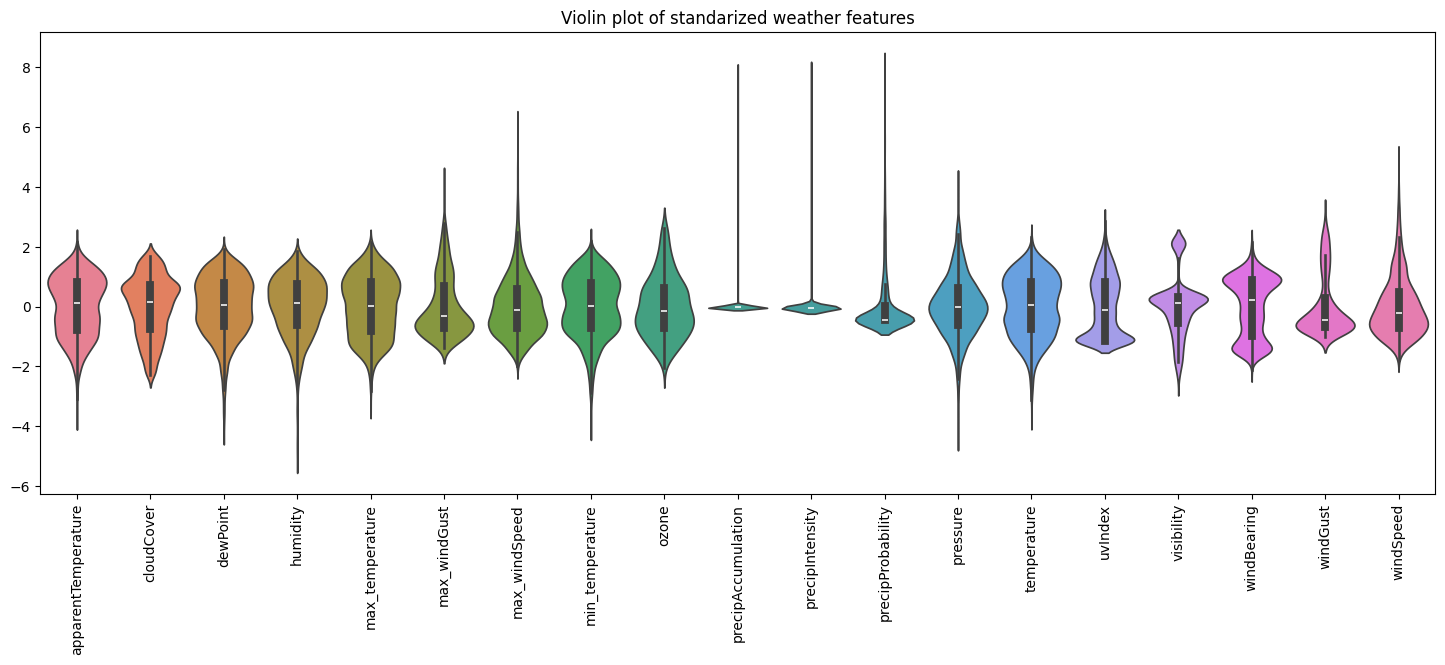

In [ ]:
# Standarize data for easier visualization
df_scaled = (df - df.mean(numeric_only=True)) / df.std(numeric_only=True)

# Clip extreme values ​​(values ​​above 8 are only observed for precipitation features)
df_scaled = df_scaled.clip(upper=8)

_, ax = plt.subplots(figsize=(18, 6))
sns.violinplot(df_scaled.drop(columns=["season"]), ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("Violin plot of standarized weather features")

### Data correlation

Most ML models works better if features used to train them are uncorrelated with each other and highly correlated with target variable.

<Axes: >

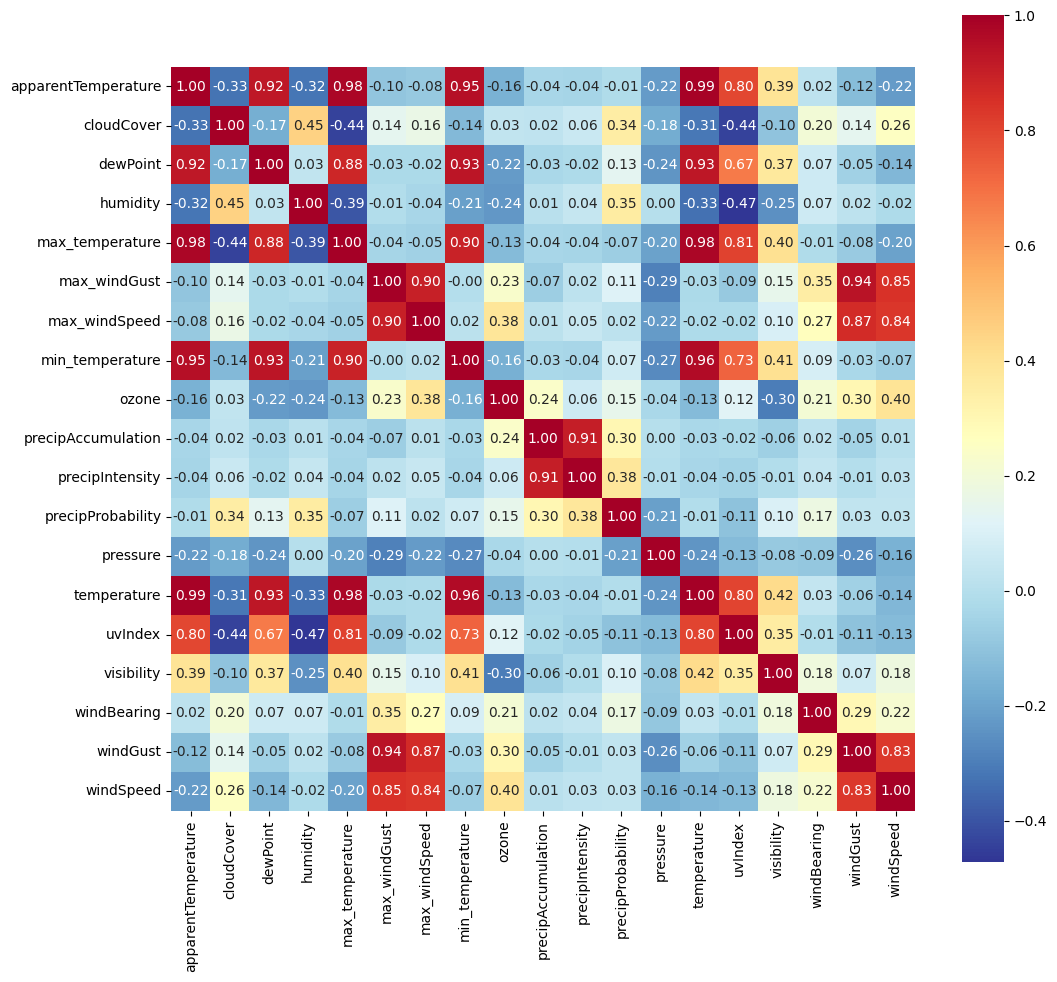

In [ ]:
_, ax = plt.subplots(figsize=(12, 11))
sns.heatmap(df.corr(numeric_only=True), cmap="RdYlBu_r", ax=ax, annot=True, fmt=".2f", square=True)

A clear correlation is found between rather obvious pairs of variables such as all temperature-related variables, `precipAccumulation` and `precipIntensity` (the heavier the precipitation, the greater the accumulation), `apparentTemperature` and `temperature`, or `windGust` and `windSpeed` (stronger gusts for higher wind speeds). A high correlation is shown by `dewPoint` and temperature variables (interesting thing is that dew point has a higher correlation with minimum temperature than maximum temperature), which is due to the fact that the dew point is calculated directly from the ambient temperature and strongly dependent on it. Some negative correlation is shown by `humidity` and `temperature`/`apparentTemperature` which may be influenced by the generally higher humidity in the spring, autumn and winter months, when the air temperature is lower than in summer.`

Another correlated pair of variables is `uvIndex` and `temperature`/`apparentTemperature` which is in turn related to the fact that there is more sunshine in summer and much less in the other, colder months.

The explanation of the correlation between UV index, `cloudCover` and `humidity` follows indirectly from the description of the two previous correlations.

### Visualizations

Visualizations can provide better or different insights about data especially related to relationships between several features. They can be useful to identify wheter or not there are outliers and missing values in the dataset.

#### Pairplots

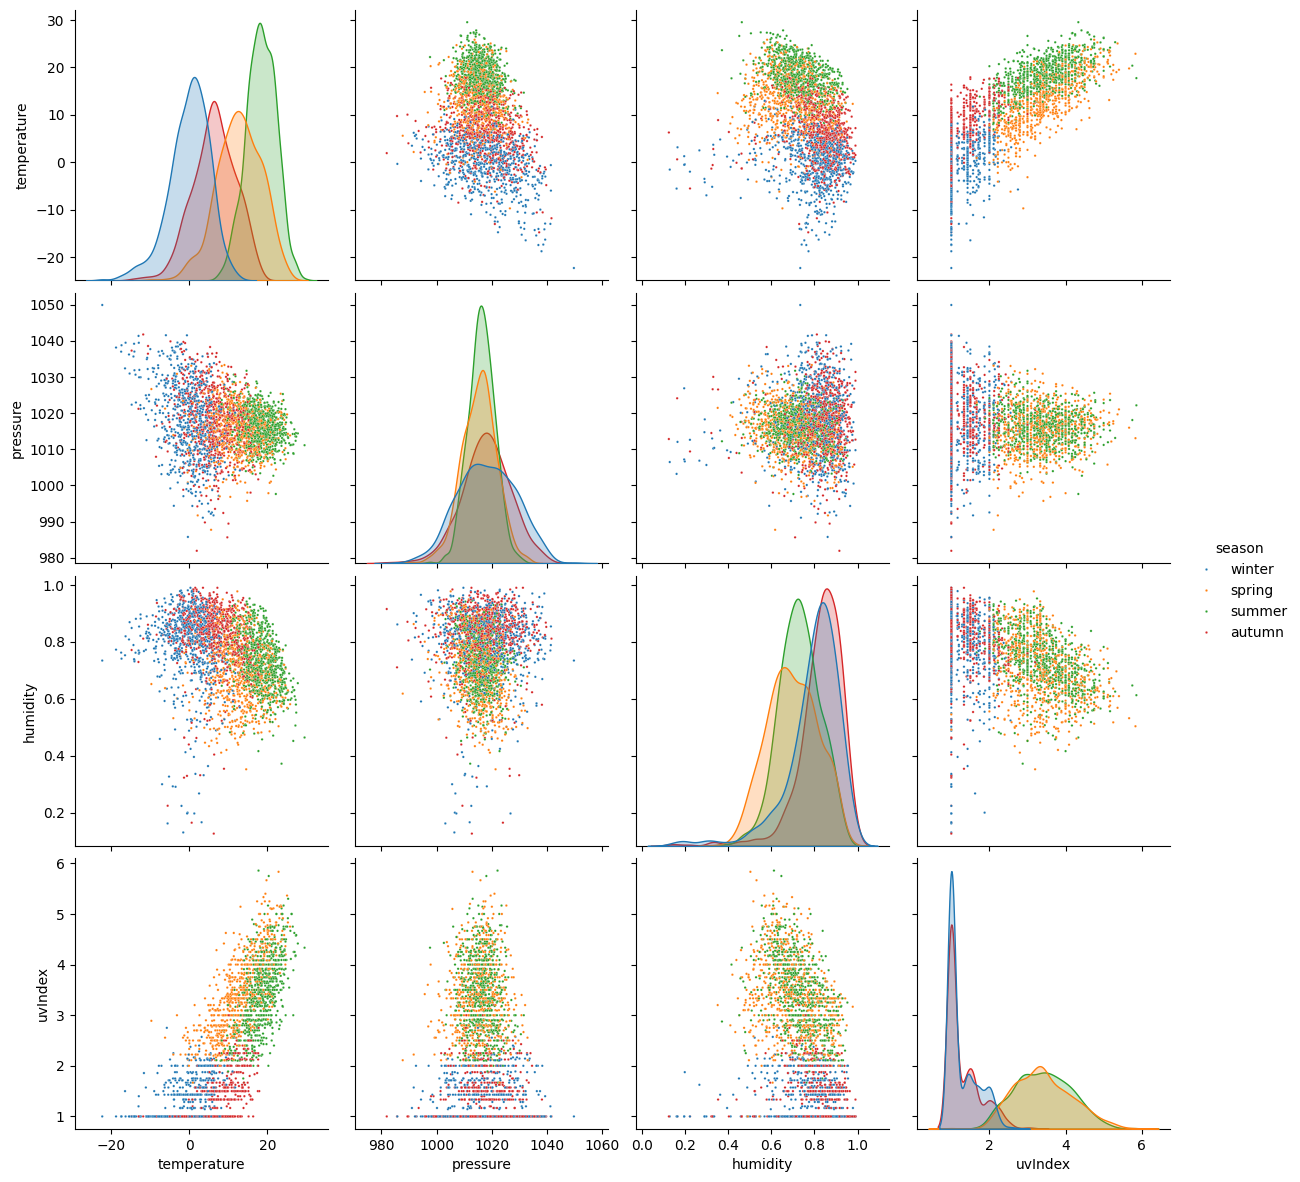

In [ ]:
pair_plot_data = df[["temperature", "pressure","humidity", "season", "uvIndex"]].reset_index(drop=True)
sns.pairplot(pair_plot_data, hue="season", height=3, plot_kws={"s": 3})

From the chart it can be concluded, among others, that:
  - The temperature and pressure distribution is very close to normal,
  - The pressure range in winter is much wider than in summer,
  - The highest insolation was observed for pressures in the range of approx. 1000-1030 hPa,
  - High temperatures are also recorded for a similar pressure range,
  - In winter, there was practically no UV index above 3,
  - The UV index is similar in winter, autumn and in spring, summer,
  - The temperature range in winter and summer is slightly smaller than in spring and autumn,
  - There are more days with humidity below 70% in summer and spring, fewer in autumn and winter,
  - The humidity is almost the same in autumn, winter and in spring, summer.

#### Temperature & humidity plots

In [ ]:
year_bins = np.linspace(2000, 2020, 5)
year_labels = [ f"{year1:.0f}-{year2:.0f}" for year1, year2 in list(zip(year_bins[:-1], year_bins[1:]))]

In [ ]:
periodic_temperature = (
    df.assign(year=lambda df: [date.year for date in df.index])
      .assign(month=lambda df: [date.month for date in df.index])
      .assign(long_term_mean=lambda df: pd.cut(df["year"], bins=year_bins, labels=year_labels))
      .groupby(["long_term_mean", "month"])
      .mean(numeric_only=True)["temperature"]
      .unstack(level="month")
)

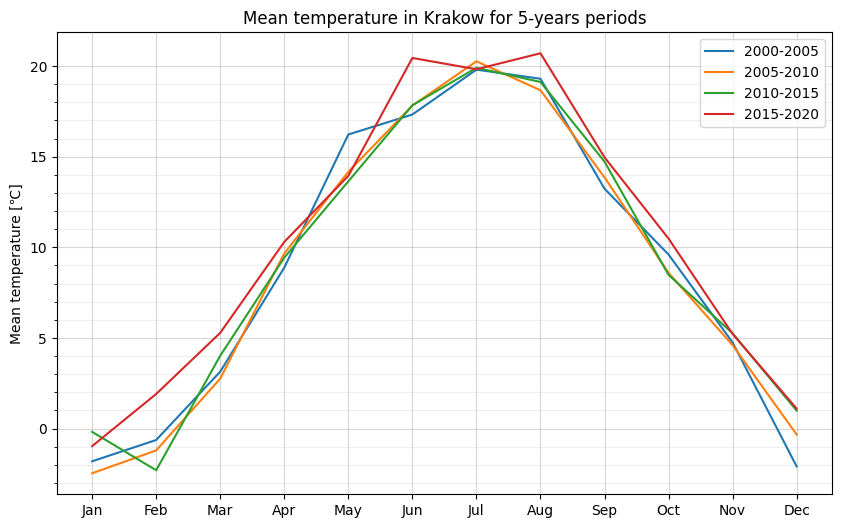

In [ ]:
_, ax = plt.subplots(figsize=(10, 6))
minor_yticks = np.arange(-5, 20, 1)
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

ax.set_title("Mean temperature in Krakow for 5-years periods")
ax.set_ylabel(u"Mean temperature [\u2103]")
ax.set_yticks(minor_yticks, minor=True)
ax.set_xticks(range(1, 13))
ax.set_xticklabels(months)
ax.grid(alpha=0.5)
ax.grid(which="minor", alpha=0.2)

for index, row in periodic_temperature.iterrows():
    ax.plot(row.index, row, label=index)

ax.legend()

The next temperature graph clearly shows global warming. It is worth noting that the greatest increase in temperature can be observed in the coldest months, mainly in January and December (the increase in February is not clear, because, for example, the periods 2000-2005 and 2005-2010 had higher temperatures than the period 2010-2015).

The sudden warming of the winter months implies a serious threat e.g. rapid melting of the accumulated snow cover and heavy rainfall for this time of year which has a direct impact on the increasing level of surface waters and a greater number of floods in winter. The most visible effect of this warming, however, is a change in the winter climate to a more autumnal one, with less snow and more rain.

The spring and autumn months warmed only slightly. Much higher average temperatures in June and August in 2015-2020 compared to other periods are due to record-breaking hot weather days at that time.

Text(0, 0.5, 'Temperature [℃]')

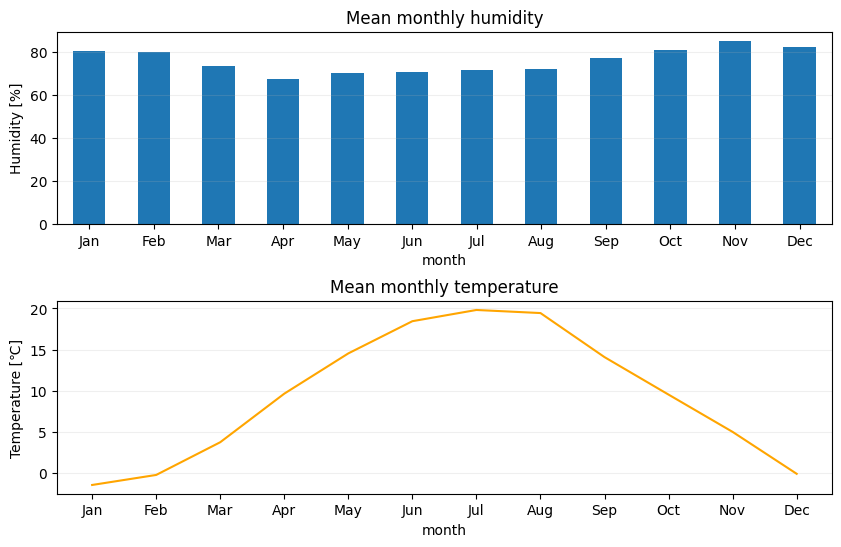

In [ ]:
periodic_data = (
    df.assign(month=lambda df: [date.month for date in df.index])
    .groupby("month")
    .mean(numeric_only=True)[["humidity", "temperature", "pressure"]]
)

fig, ax = plt.subplots(2, figsize=(10, 6))

(periodic_data["humidity"] * 100).plot.bar(ax=ax[0])
periodic_data["temperature"].plot.line(ax=ax[1], c="orange")

fig.subplots_adjust(hspace=0.4)
ax[0].set_title("Mean monthly humidity")
ax[1].set_title("Mean monthly temperature")
ax[0].grid(axis="y", alpha=0.2)
ax[1].grid(axis="y", alpha=0.2)

ax[0].set_xticks(range(0, 12))
ax[0].set_xticklabels(months, rotation=0)
ax[0].set_ylabel("Humidity [%]")

ax[1].set_xticks(range(1, 13))
ax[1].set_xticklabels(months)
ax[1].set_ylabel(u"Temperature [\u2103]")

From figure above it can be concluded that there is a significant relationship between temperature and humidity air in individual months. In the warmest months, air humidity is much lower than in the remaining months. It is worth noting that in the spring and autumn months, despite similar air temperatures, air humidity differs slightly, which may help classify days into seasons.

#### Pressure plots

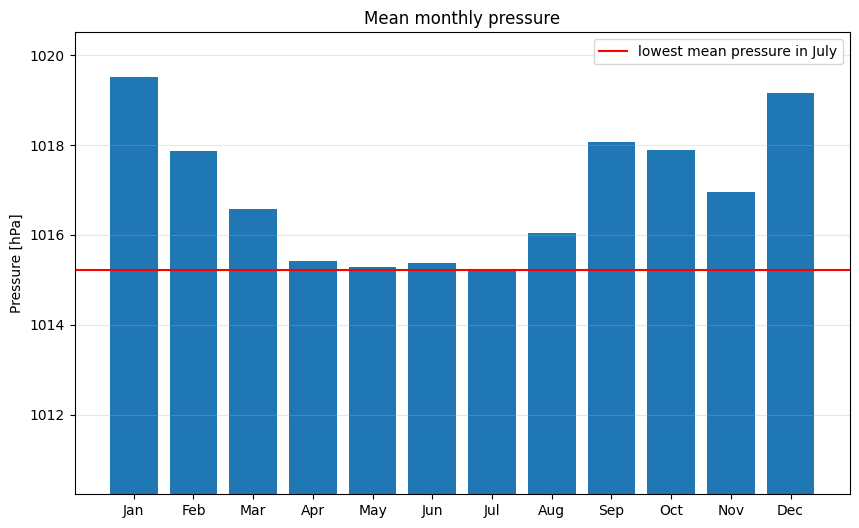

In [ ]:
pressure = periodic_data["pressure"]

_, ax = plt.subplots(figsize=(10, 6))
ax.bar(months, pressure,)
ax.set_title("Mean monthly pressure")
ax.set_ylabel("Pressure [hPa]")
ax.set_ylim([pressure.min() - 5, pressure.max() + 1])
ax.grid(axis="y", alpha=0.3)
ax.axhline(y=pressure.min(), c="red", label="lowest mean pressure in July")
ax.legend()

The average monthly atmospheric pressure presented above shows a certain tendency according to which late spring and early summer months are characterized by lower pressure than the rest. The red line marks the lowest average pressure in July. However, the differences are not clear and on the scale of single days they may turn out to be a less useful indicator of the season in the context of the classification problem under consideration.

## Data preprocessing and cleaning

#### Choosing uncorrelated features

In [ ]:
df = df[["temperature", "pressure", "humidity", "season", "precipAccumulation", "windSpeed", "visibility", "cloudCover", "ozone", "windBearing"]]

#### Handling missing data

There are many methods for dealing with missing data. The easiest of these is to remove all observations that have missing values for at least one feature. Other techniques involve assigning certain values, e.g. constant, mean, median, most common value. In the case of time series, missing values can be filled in with value from the previous or next observation.

In our case, we will use a slightly different approach - we will use other, similar observations to calculate the fill value for each feature separately. This can be done using, among others: linear or kNN regression.

In [ ]:
x = df.drop(columns=["season"])
X_columns = x.columns
X = x.values

X = KNNImputer().fit_transform(X)
y = LabelEncoder().fit_transform(df["season"])

#### Handling outliers

It is common practice to treat outliers if their number is significant. However, the data used in this project do not contain large numbers of outliers and therefore no removal or other type of transformation was performed.

### Dimensionality reduction & feature selection

Multi dimensional data is problematic for several reasons: first of all, the more features a model has, the larger it becomes, which ultimately leads to long calculations. Secondly, the more features that are introduced into the model, the more complex the model becomes and the more likely it is to overfit the learning data and have low generalisability.

In addition, a more complex model is more susceptible to various types of noise in the data and its accuracy usually decreases in such a situation. It is also important to note that a model with, for example, 10 features is easier to manage than one with 100 features.

Taking these arguments into account, one should always strive for the so-called *parsimonious* model, i.e. the best possible model in terms of the results obtained and, at the same time, the simplest possible model.

In [ ]:
pipe = make_pipeline(StandardScaler(), PCA(n_components=X.shape[1], random_state=42))
X_transformed = pipe.fit_transform(X)

In [ ]:
np.cumsum(pipe.named_steps["pca"].explained_variance_ratio_)

array([0.23098858, 0.42035913, 0.5477413 , 0.6586017 , 0.7552699 ,
       0.83893186, 0.90446657, 0.95632845, 0.99999994], dtype=float32)

<BarContainer object of 9 artists>

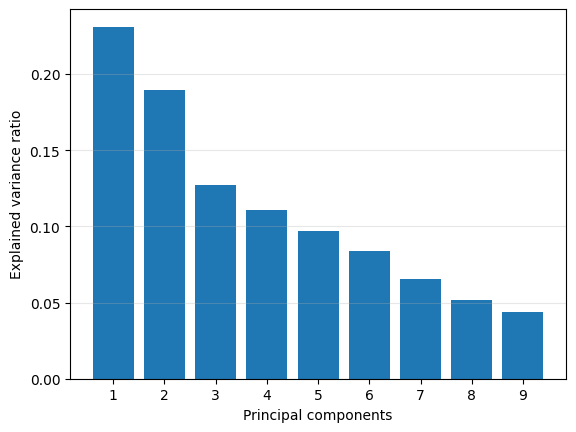

In [ ]:
cpv = np.cumsum(pipe.named_steps["pca"].explained_variance_ratio_)

_, ax = plt.subplots()

ax.set_xlabel("Principal components")
ax.set_ylabel("Explained variance ratio")
ax.grid(axis="y", alpha=0.3)
ax.set_xticks(range(1, cpv.size + 1))
ax.bar(x=range(1, cpv.size + 1), height=pipe.named_steps["pca"].explained_variance_ratio_)

In [ ]:
pca = pipe.named_steps["pca"]
principal_names = [f"z{i+1}" for i in range(pca.components_.shape[0])]

pd.DataFrame(data=pca.components_, columns=X_columns, index=principal_names).assign(
    explained_variance_ratio=pca.explained_variance_ratio_,
    explained_variance=np.cumsum(pca.explained_variance_ratio_),
)

,temperature,pressure,humidity,precipAccumulation,windSpeed,visibility,cloudCover,ozone,windBearing,explained_variance_ratio,explained_variance
z1,-0.51,0.01,0.46,0.04,0.25,-0.31,0.50,0.30,0.18,0.23,0.23
z2,0.28,-0.35,-0.15,0.01,0.45,0.48,0.16,0.29,0.48,0.19,0.42
z3,-0.24,0.61,-0.38,0.07,0.17,-0.00,-0.35,0.50,0.12,0.13,0.55
z4,0.02,-0.04,-0.01,1.00,-0.05,0.01,0.01,-0.06,0.00,0.11,0.66
z5,-0.16,-0.44,-0.38,0.02,0.48,-0.28,-0.08,0.09,-0.56,0.10,0.76
z6,-0.13,0.43,0.06,0.01,0.47,0.45,0.23,-0.48,-0.28,0.08,0.84
z7,0.21,0.04,0.32,0.02,-0.19,0.38,0.11,0.57,-0.58,0.07,0.90
z8,-0.15,0.04,-0.61,-0.02,-0.39,0.09,0.66,0.03,-0.04,0.05,0.96
z9,-0.71,-0.34,0.04,-0.01,-0.23,0.49,-0.31,-0.04,0.04,0.04,1.00


Approximately 95% of the data variance is explained by the first 8 principal components. The greatest influence on the:
  - first component - temperature,
  - second - visibility and wind direction,
  - third - pressure,
  - fourth - precipitation accumulation
  - fifth - wind direction,
  - sixth - wind speed and ozone,
  - seventh - wind direction,
  - eighth - cloud cover,
  - ninth - temperature.

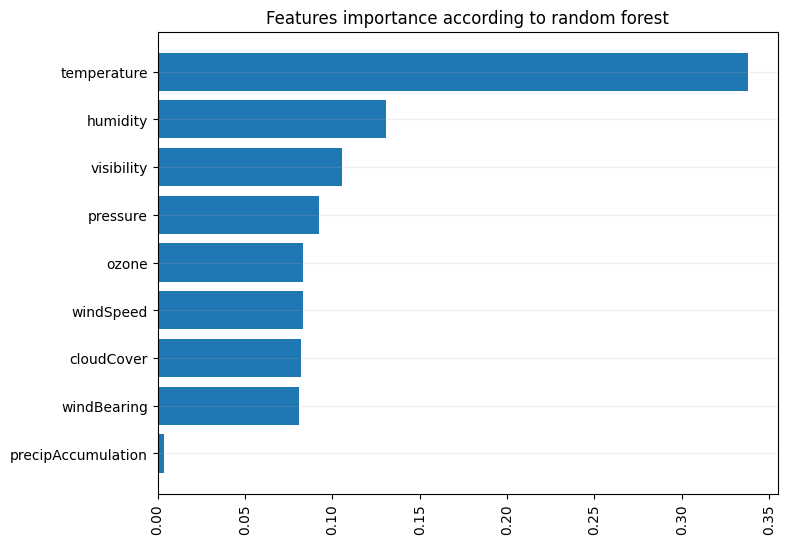

In [ ]:
forest = RandomForestClassifier()
forest.fit(X, y)

importances = sorted(list(zip(forest.feature_importances_, list(X_columns))))
importance = [importance for (importance, _) in importances]
names = [name for (_, name) in importances]

_, ax = plt.subplots(figsize=(8, 6))
ax.set_title("Features importance according to random forest")
ax.barh(names, importance)
ax.grid(axis="y", alpha=0.2)
ax.tick_params(axis='x', labelrotation=90)

As expected, `temperature` matters most according to random forest. `humidity`, `visibility` and `pressure` are less important. The variables `windSpeed`, `windBearing`, `ozone` and `cloudCover` have a similar meaning. The least important is feature related to rainfall accumulation.

### Data preprocessing pipeline

In order to make it as easy as possible to manage the training, testing and optimisation of the hyperparameters for each model, a data pipeline has been developed - a special object available in the sklearn library, which allows data preprocessing (labeling, standardisation, discretisation, etc.), the possible removal of outliers and other necessary data processing.

The created created stream consists of the following steps:
  1. Include only the most important features, such as `temperature`, `humidity`, `visibility`, `pressure`, `cloudCover`,
  2. Group the data by date and calculate daily averages,
  3. Determie the season for each day,
  4. Fill in missing values using the kNN algorithm,
  5. Label of season as 0, 1, 2, 3,
  6. Standardise of `X` features.

In [ ]:
df_to_preprocess = pd.read_csv(DATA_PATH)
df_to_preprocess["time"] = pd.to_datetime(df_to_preprocess["time"], unit="s", utc=True).dt.tz_convert(tz="Europe/Warsaw")

In [ ]:
def preprocess(df: pd.DataFrame,
        include_columns: list[str],
        time_column: str = "time",
        test_size: float=0.2,
        random_state: int=42
    ) -> tuple[npt.NDArray, npt.NDArray, npt.NDArray, npt.NDArray]:
    """Preprocess raw pandas DataFrame.

    Args:
        include_columns (list[str]): Which column to include in output
        time_column (str, optional): DataFrame datetime column name. Default to 'time'
        test_size (float, optional): The size of test dataset. Default to 0.2
        random_state (int, optional): Rng seed. Default to 42

    Returns:
         tuple[npt.NDArray, npt.NDArray, npt.NDArray, npt.NDArray]: Preprocessed
         X_train, X_test, y_train, y_test datasetst
    """
    season_extractor = FunctionTransformer(lambda dates: np.array([(determine_season(date)) for date in dates])[..., np.newaxis])
    daily_means_transformer = FunctionTransformer(lambda x: x.groupby(x[time_column].dt.date).mean(numeric_only=True).reset_index())

    pipeline = make_pipeline(
        daily_means_transformer,
        make_column_transformer((
            make_pipeline(
                season_extractor,
                FunctionTransformer(lambda x: LabelEncoder().fit_transform(x.ravel())[..., np.newaxis]),
            ),
            time_column),
            ("passthrough", include_columns)
        ),
        KNNImputer(),
    )

    data = pipeline.fit_transform(df)
    X = data[..., 1:]
    y = data[..., 0]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    std_scaler = StandardScaler()
    std_scaler.fit(X_train)

    return std_scaler.transform(X_train), std_scaler.transform(X_test), y_train, y_test


X_train, X_test, y_train, y_test = preprocess(df_to_preprocess, ["temperature", "humidity", "visibility", "pressure", "cloudCover"])
X_train[:5], X_test[:5], y_train[:5], y_test[:5]

(array([[ 0.37450441, -1.03995187,  2.37782268, -0.87931042, -0.35842025],
        [ 0.90015192, -0.21710938,  0.42255195,  0.17010078, -1.18557139],
        [-0.58860455, -0.05186642, -0.78468237,  1.54386559, -0.45777269],
        [-1.12236225,  0.45735168, -0.9475312 , -1.09319969,  1.38108938],
        [-0.61567108, -0.68923212, -2.8566135 ,  0.52694391,  1.74650428]]),
 array([[-0.11225329, -0.72969978, -0.36563536,  0.52694391,  0.31852348],
        [-1.3472489 ,  0.83842218, -0.21208066,  2.02687632,  0.7361405 ],
        [ 0.04506476,  0.6563177 , -0.35609388, -0.3026216 , -0.33773185],
        [ 0.72426837, -1.51207461,  0.4174767 ,  0.82476442, -1.32132755],
        [ 0.07843378,  1.37124642, -0.45146359,  0.32767491,  0.778239  ]]),
 array([1., 2., 3., 3., 0.]),
 array([1., 0., 0., 2., 0.]))

## Model training & evaluation

At this stage of the project, the main goal is to create basic machine learning models, which can be both classical statistical models (e.g.  k-nearest-neighbour algorithm, decision tree, random forest) and models based on artificial neural networks (SSNs). SSN models, however, are not the focus of the project described and are not included.

A k-fold cross-validation on the training set was used to train the models. The value of k is typically 3, 5 or 10. The `cross_val_score()` method available in the sklearn library was used for cross-validation.

In [ ]:
acc = cross_val_score(LogisticRegression(), X_train, y_train, cv=5)
acc.mean(), acc.std()

(0.6526040417499445, 0.024608334691839807)

In [ ]:
acc = cross_val_score(SVC(decision_function_shape="ovo", kernel="rbf"), X_train, y_train, cv=5)
acc.mean(), acc.std()

(0.6703184543637575, 0.005377736282834955)

In [ ]:
acc = cross_val_score(RandomForestClassifier(), X_train, y_train, cv=5)
acc.mean(), acc.std()

(0.6656779924494781, 0.00539825551309672)

The differences in the performance quality of the models are not significant. SVM has the highest accuracy (67%), which is also the most stable. Random forest achieves similar results with slightly lower accuracy. Logistic regression performs slightly worse, as it is both less accurate and less stable.

### Ensemble learning

Ensemble learning involves combining several models and averaging their results to eliminate the weaknesses of the individual models. In theory, if the models' errors are not correlated with each other, this way of prediction should give much higher results than each model separately. In practice, however, the errors are rarely uncorrelated so the improvement in performance is not as great as might be expected and rarely is the score of an ensemble learning model much higher than that of the best single model.

In [ ]:
vote = VotingClassifier([
    ("tree", DecisionTreeClassifier()),
    ("svc", SVC(decision_function_shape="ovo", probability=True)),
    ("forest", RandomForestClassifier())
])

acc = cross_val_score(vote, X_train, y_train, cv=5)
acc.mean(), acc.std()

(0.656833222296247, 0.007177929768086415)

### Hyperparemter optimization

The optimisation of a model and, more specifically, of its hyperparameters, i.e. the parameters that are given even before learning starts, is an important and at the same time difficult task. It is very difficult to assess which values will be best for which hyperparameters.

The basic optimisation methods are:
  - manual value adjustment,
  - GridSearch,
  - RandomisedSearch,
  - genetic algorithms
  - evolutionary algorithms,
  - Bayes optimisation methods,
  - gradient-based methods for hyperparameter functions.

In [ ]:
class Objective:
    def __init__(self, model, X_train, y_train=None, cv: int = 5) -> None:
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.cv = cv

    def __call__(self, trial: optuna.Trial) -> tuple[float, float]:
        self.model.set_params(**self._create_params(trial))
        cv_accuracy = cross_val_score(self.model, X_train, y_train, cv=self.cv, scoring="accuracy", n_jobs=-1)
        return cv_accuracy.mean(), cv_accuracy.std()

    def _create_params(self, trial: optuna.Trial):
        svm_params = {
            "svc__C": trial.suggest_float("svc__C", 1e-4, 1e2, log=True),
            "svc__kernel": trial.suggest_categorical("svc__kernel", ["rbf", "linear", "sigmoid", "poly"]),
            "svc__degree": trial.suggest_int("svc__degree", 1, 4),
        }

        forest_params = {
            "forest__n_estimators": trial.suggest_int("forest__n_estimators", 100, 200, step=10),
            "forest__min_samples_leaf": trial.suggest_int("forest__min_samples_leaf", 50, 100, step=10),
            "forest__max_features": trial.suggest_categorical("forest__max_features", [None, 3, 4, 5, 6])
        }

        tree_params = {
            "tree__max_depth": trial.suggest_int("tree__max_depth", 2, 8),
            "tree__min_samples_leaf": trial.suggest_int("tree__min_samples_leaf", 5, 50, step=5),
            "tree__max_features": trial.suggest_categorical("tree__max_features", [None, 3, 4, 5, 6])
        }

        ensemble_params = svm_params | forest_params | tree_params
        ensemble_params["voting"] = trial.suggest_categorical("voting", ["hard", "soft"])
        return ensemble_params

In [ ]:
study = optuna.create_study(directions=["maximize", "minimize"])
study.optimize(Objective(vote, X_train, y_train), n_trials=200, n_jobs=-1, timeout=3600)

[I 2024-03-02 08:03:58,910] A new study created in memory with name: no-name-5ff95463-011a-4bb6-b9b1-9cc4a8524a99
[I 2024-03-02 08:04:21,959] Trial 1 finished with values: [0.6416380190983788, 0.01926081599146657] and parameters: {'svc__C': 0.0001952872390177423, 'svc__kernel': 'sigmoid', 'svc__degree': 1, 'forest__n_estimators': 100, 'forest__min_samples_leaf': 100, 'forest__max_features': None, 'tree__max_depth': 6, 'tree__min_samples_leaf': 50, 'tree__max_features': 4, 'voting': 'soft'}. 
[I 2024-03-02 08:04:22,091] Trial 0 finished with values: [0.6420590717299577, 0.02617655571871203] and parameters: {'svc__C': 30.710162296044295, 'svc__kernel': 'sigmoid', 'svc__degree': 3, 'forest__n_estimators': 130, 'forest__min_samples_leaf': 90, 'forest__max_features': 3, 'tree__max_depth': 7, 'tree__min_samples_leaf': 40, 'tree__max_features': 3, 'voting': 'hard'}. 
[I 2024-03-02 08:04:38,588] Trial 2 finished with values: [0.6648376637797024, 0.012204553053107537] and parameters: {'svc__C':

In [ ]:
study.trials_dataframe().sort_values(["values_0", "values_1"], ascending=False).reset_index(drop=True).set_index("number").rename(columns={"values_0": "cv_accuracy", "values_1": "cv_std"}).head()

,cv_accuracy,cv_std,datetime_start,datetime_complete,duration,params_forest__max_features,params_forest__min_samples_leaf,params_forest__n_estimators,params_svc__C,params_svc__degree,params_svc__kernel,params_tree__max_depth,params_tree__max_features,params_tree__min_samples_leaf,params_voting,system_attrs_nsga2:generation,state
number,,,,,,,,,,,,,,,,,
181,0.67,0.03,2024-03-02 08:29:57.049441,2024-03-02 08:30:11.941221,0 days 00:00:14.891780,3.00,60,160,40.40,1,rbf,7,3.00,20,soft,3,COMPLETE
50,0.67,0.02,2024-03-02 08:12:02.260664,2024-03-02 08:12:26.556456,0 days 00:00:24.295792,3.00,80,130,3.51,3,rbf,7,4.00,20,soft,0,COMPLETE
132,0.67,0.02,2024-03-02 08:23:49.160840,2024-03-02 08:24:01.819059,0 days 00:00:12.658219,3.00,50,130,53.99,4,rbf,8,4.00,20,soft,2,COMPLETE
124,0.67,0.01,2024-03-02 08:22:56.542923,2024-03-02 08:23:09.274272,0 days 00:00:12.731349,4.00,100,150,0.55,1,rbf,5,4.00,15,soft,2,COMPLETE
174,0.67,0.01,2024-03-02 08:28:42.914455,2024-03-02 08:28:59.328830,0 days 00:00:16.414375,5.00,60,100,0.55,3,rbf,4,6.00,50,soft,3,COMPLETE


Text(0, 0.5, '5-fold CV mean accuracy')

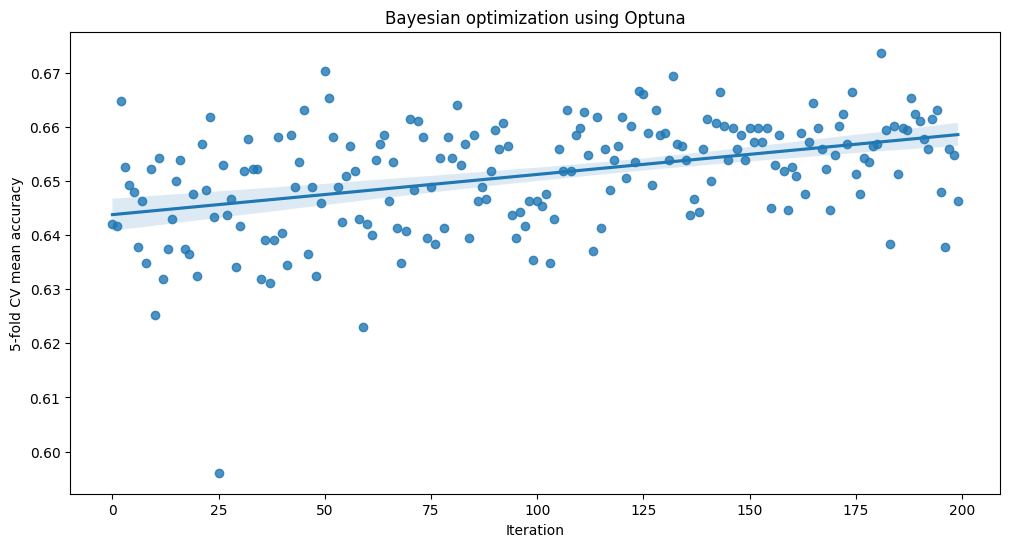

In [ ]:
_, ax = plt.subplots(figsize=(12, 6))

sns.regplot(x=np.arange(study.trials_dataframe().shape[0]), y=study.trials_dataframe()["values_0"], ax=ax)
ax.set_title("Bayesian optimization using Optuna")
ax.set_xlabel("Iteration")
ax.set_ylabel("5-fold CV mean accuracy")

Bayesian optimisation in successive iterations searches more specific regions of the space of hyperparameters that optimise the objective function which is visible as increasingly less haotic points on the graph. There is an upward trend in the results given by the Bayes methods. As successive iterations are performed, the algorithm obtains better and better results while slightly reducing the variance of the new results.

### Best voting classifier evaluation & error analysis

In [ ]:
lb = LabelEncoder()
lb.fit_transform(df["season"])
lb.classes_

array(['autumn', 'spring', 'summer', 'winter'], dtype=object)

In [ ]:
best_vote = vote.set_params(**study.trials[181].params)
best_vote.fit(X_train, y_train)

VotingClassifier(estimators=[('tree',
                              DecisionTreeClassifier(max_depth=7,
                                                     max_features=3,
                                                     min_samples_leaf=20)),
                             ('svc',
                              SVC(C=40.40299568651465,
                                  decision_function_shape='ovo', degree=1,
                                  probability=True)),
                             ('forest',
                              RandomForestClassifier(max_features=3,
                                                     min_samples_leaf=60,
                                                     n_estimators=160))],
                 voting='soft')

In [ ]:
y_score = best_vote.predict_proba(X_test)
y_pred = best_vote.predict(X_test)

In [ ]:
binarizer = LabelBinarizer()
binarizer.fit(y_train)
y_test_onehot = binarizer.transform(y_test)
target_labels = dict(zip(lb.classes_, map(int, binarizer.classes_)))
target_labels

{'autumn': 0, 'spring': 1, 'summer': 2, 'winter': 3}

In [ ]:
print(classification_report(y_test, y_pred, target_names=lb.classes_))

              precision    recall  f1-score   support

      autumn       0.66      0.43      0.52       144
      spring       0.66      0.52      0.58       155
      summer       0.66      0.85      0.74       155
      winter       0.64      0.81      0.72       140

    accuracy                           0.65       594
   macro avg       0.66      0.65      0.64       594
weighted avg       0.66      0.65      0.64       594



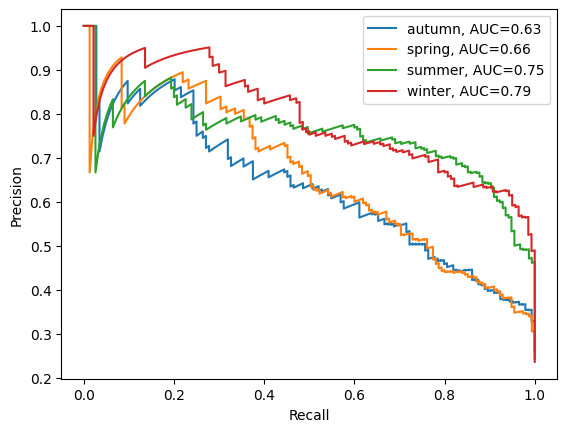

In [ ]:
_, ax = plt.subplots()
precisions = {}
recalls = {}

for label, i in target_labels.items():
    precision, recall, _ = precision_recall_curve(y_test_onehot[..., i], y_score[..., i])
    ax.plot(recall, precision, label=f"{label}, AUC={auc(recall, precision):.2f}")

ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend()

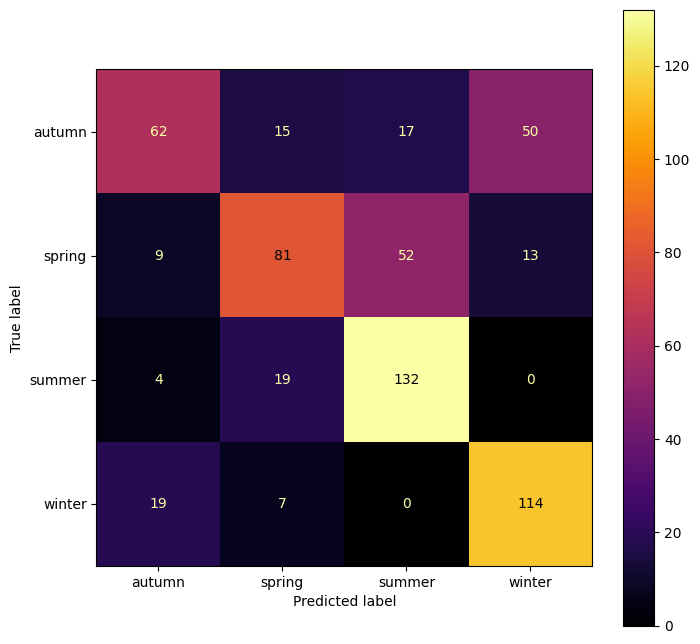

In [ ]:
_, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=lb.classes_).plot(ax=ax, cmap="inferno")

As expected, the model do not have good performance quality, which is due to the fact that the classification of days into seasons is too complicated task for such simple model, especially in the case of days on the edge of two different seasons. Moreover, the boundary of the calendar seasons does not reflect the weather conditions on these days, e.g. two consecutive days, one in autumn and the other in winter, may have identical weather and yet be in two different seasons.

The easiest season to classify was summer, and the most difficult was autumn.

There are no cases of confusion between summer and winter days and vice versa. This proves that the model can perfectly classify such different weather conditions.